# Example 6. Testing different CNN architectures

In [1]:
import sys

sys.path.append('..')   # add gojo path

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# GOJO libraries
from gojo import deepl
from gojo import plotting
from gojo import core
from gojo import util

DEVICE = 'cuda'

## Data loading

In [2]:
# FashionMNIST labels (https://github.com/zalandoresearch/fashion-mnist)
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# define the transformation used to load the images
transform = transforms.Compose([
    transforms.ToTensor(), 
])

# download the FashionMNIST datasets (train/test)
train_dataset = datasets.FashionMNIST(
    root=os.path.join(os.path.expanduser('~'), 'test_datasets', 'pytorch'), 
    train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(
    root=os.path.join(os.path.expanduser('~'), 'test_datasets', 'pytorch'), 
    train=False, transform=transform, download=True)

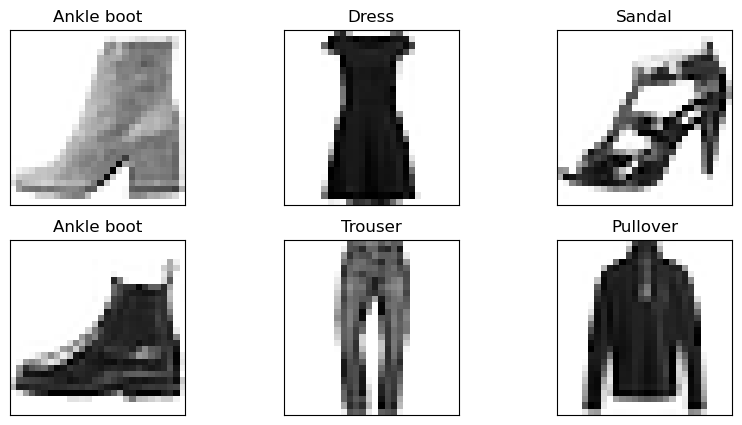

In [3]:
# plot some examples
np.random.seed(1997)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset[np.random.choice(len(train_dataset))]
    img_np = img.numpy().squeeze(0)    
    
    ax.imshow(img_np, cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[label])
plt.show()

In [4]:
# separate the training data into train (85%) and validation (15%)
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, 
    [
        int(len(train_dataset) * 0.85),
        int(len(train_dataset) * 0.15)
    ],
    torch.Generator().manual_seed(1997)
)

print('Train: %d' % len(train_dataset))
print('Valid: %d' % len(valid_dataset))
print('Test: %d' % len(test_dataset))

# create the dataloaders
train_dl = DataLoader(
    train_dataset, 
    batch_size=2048, shuffle=True)

valid_dl = DataLoader(
    valid_dataset, 
    batch_size=4096, shuffle=False)

test_dl = DataLoader(
    test_dataset, 
    batch_size=4096, shuffle=False)

Train: 51000
Valid: 9000
Test: 10000


## Vanilla CNN

In [5]:
v_cnn = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(8),
    
        torch.nn.Conv2d(8, 16, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),
        torch.nn.MaxPool2d(2),
        
        torch.nn.Conv2d(16, 32, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(32),
        torch.nn.MaxPool2d(2),
    
        torch.nn.Conv2d(32, 64, (2, 2)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(64),
        torch.nn.AvgPool2d(2),
        
        torch.nn.Flatten(),
    
        torch.nn.Linear(256, 64),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10),
)

print('Number of model trainable parameters: %d' % util.tools.getNumModelParams(v_cnn))

Number of model trainable parameters: 31482


In [6]:
output_v_cnn = deepl.fitNeuralNetwork(
    deepl.iterSupervisedEpoch,
    model=v_cnn,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=40,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.0001},
    device=DEVICE,
)

Training model...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:05<00:00,  1.63s/it]


### Model convergence

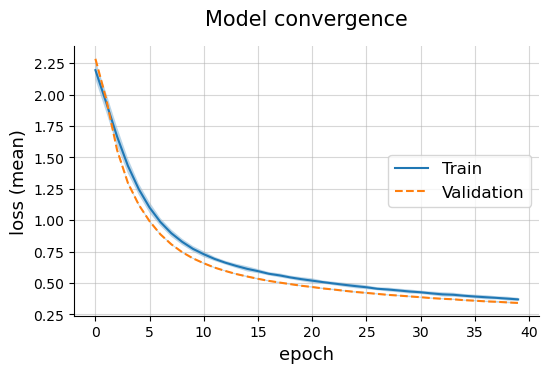

In [7]:
plotting.linePlot(
    output_v_cnn['train'], 
    output_v_cnn['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

### Model evaluation

In [8]:
# make model predictions
v_cnn = v_cnn.eval()
y_hat = []
y_true = []
with torch.no_grad():
    for X, y in tqdm(test_dl, desc='Performing predictions...'):
        # convert logits to probabilities
        _y_hat = torch.nn.functional.softmax(v_cnn(X.to(device=DEVICE)), dim=1).cpu().numpy()
        
        # convert from one-hot encoding to integer-coding
        y_hat.append(_y_hat.argmax(axis=1))
        y_true.append(y.numpy())
        
y_hat = np.concatenate(y_hat)
y_true = np.concatenate(y_true)

# calculate per-class accuracy
acc_per_label = {}
for label_key, label in labels.items():
    y_true_bin = (y_true == label_key).astype(int)
    y_hat_bin = (y_hat == label_key).astype(int)
    
    # compute accuracy
    acc_per_label[label] = core.getScores(
        y_true_bin,
        y_hat_bin,
        metrics=core.getDefaultMetrics('binary_classification', ['accuracy'])
    )['accuracy']

print('Average accuracy: %.3f' % np.mean(list(acc_per_label.values())))
pd.DataFrame([acc_per_label], index=['Accuracy']).T

Performing predictions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.08it/s]

Average accuracy: 0.974


,Accuracy
T-shirt/top,0.9642
Trouser,0.9958
Pullover,0.9539
Dress,0.9758
Coat,0.9520
Sandal,0.9928
Shirt,0.9302
Sneaker,0.9903
Bag,0.9922
Ankle boot,0.9914


## CNN with residual connections

In [9]:
res_cnn = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, (3, 3), stride=2),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(8),
        
        deepl.cnn.ResNetBlock(8, 16, kernel_size=3),
        torch.nn.MaxPool2d(2),
    
        deepl.cnn.ResNetBlock(16, 32, kernel_size=3),
        torch.nn.MaxPool2d(2),
    
        torch.nn.Flatten(),
    
        torch.nn.Linear(288, 64),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10),
)

print('Number of model trainable parameters: %d' % util.tools.getNumModelParams(res_cnn))

Number of model trainable parameters: 37546


In [10]:
output_res_cnn = deepl.fitNeuralNetwork(
    deepl.iterSupervisedEpoch,
    model=res_cnn,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=40,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.0001},
    device=DEVICE,
)

Training model...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:56<00:00,  1.42s/it]


### Model convergence

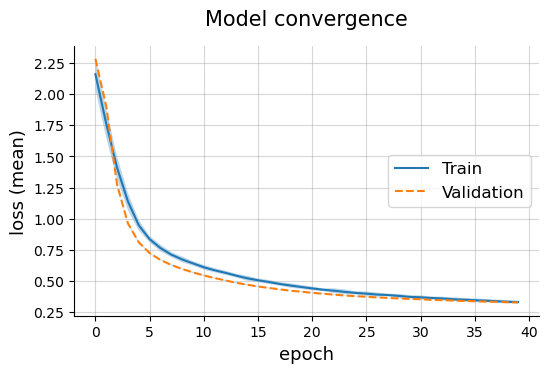

In [11]:
plotting.linePlot(
    output_res_cnn['train'], 
    output_res_cnn['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

### Model evaluation

In [12]:
# make model predictions
res_cnn = res_cnn.eval()
y_hat = []
y_true = []
with torch.no_grad():
    for X, y in tqdm(test_dl, desc='Performing predictions...'):
        # convert logits to probabilities
        _y_hat = torch.nn.functional.softmax(res_cnn(X.to(device=DEVICE)), dim=1).cpu().numpy()
        
        # convert from one-hot encoding to integer-coding
        y_hat.append(_y_hat.argmax(axis=1))
        y_true.append(y.numpy())
        
y_hat = np.concatenate(y_hat)
y_true = np.concatenate(y_true)

# calculate per-class accuracy
acc_per_label = {}
for label_key, label in labels.items():
    y_true_bin = (y_true == label_key).astype(int)
    y_hat_bin = (y_hat == label_key).astype(int)
    
    # compute accuracy
    acc_per_label[label] = core.getScores(
        y_true_bin,
        y_hat_bin,
        metrics=core.getDefaultMetrics('binary_classification', ['accuracy'])
    )['accuracy']

print('Average accuracy: %.3f' % np.mean(list(acc_per_label.values())))
pd.DataFrame([acc_per_label], index=['Accuracy']).T

Performing predictions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.44it/s]

Average accuracy: 0.974


,Accuracy
T-shirt/top,0.9625
Trouser,0.9950
Pullover,0.9581
Dress,0.9748
Coat,0.9540
Sandal,0.9928
Shirt,0.9287
Sneaker,0.9878
Bag,0.9932
Ankle boot,0.9899
